In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import glob
from pathlib import Path
import os
import matplotlib.pyplot as plt
import re

# Build Data Loader
Practice building the data loader that Pytorch will use.

Good reseource on building data loader: https://github.com/ugent-korea/pytorch-unet-segmentation/blob/master/src/dataset.py

... and here too: https://github.com/utkuozbulak/pytorch-custom-dataset-examples

In [2]:
root_dir = Path.cwd().parent # set the root directory as a Pathlib path
print(root_dir)

path_input_folder = root_dir / 'data/processed/input'
path_truth_folder = root_dir / 'data/processed/truth'

/home/tim/Documents/earth-mantle-surrogate


Build data loader.

In [3]:
class EarthDataTrain(Dataset):
    
    def __init__(self, path_input_folder, path_truth_folder, random_roll=True, gen_input_width=10, gen_output_width=38):
        """
        Args:
            path_input_folder (Pathlib path): Input (downsampled) folder directory.
            path_truth_folder (Pathlib path): Truth folder directory.
            random_roll (True or False): Whether or not to roll about the longitudinal (north-south) axis
            gen_input_width (int): Width of data that will be fed into generator. (default is 10)
            gen_output_width (int): Width of output from generator. (should be 38 on default)
            
        """
        self.random_roll = random_roll # boolean for rolling or not
        self.gen_input_width = gen_input_width # width of the downsampled data to kept and fed into generator
        self.gen_output_width = gen_output_width # width of the output from the generator
        self.path_input_folder = path_input_folder
        self.path_truth_folder = path_truth_folder
        
        file_list_truth = list(path_truth_folder.rglob('*.npy'))
        file_list_input = list(path_input_folder.rglob('*.npy'))
        
        # get each of the unique time steps (stored as a list)
        self.time_step_list = list(set(re.findall('[0-9]+', str(i))[-1] for i in file_list_truth))
        
        # len data (number of unique samples)
        self.data_len = len(self.time_step_list)
        
        # check that the same time steps in each folder
        # we use sets to find the unique time steps in the downsample and truth folders
        # and then use difference to find any samples that don't have a matching pair
        unique_steps_input = set(re.findall('[0-9]+', str(i))[-1] for i in file_list_input)
        check_1 = unique_steps_input.difference(self.time_step_list)
        check_2 = set(self.time_step_list).difference(unique_steps_input)
        
        assert len(check_1) == 0, f'missing truth or input time step sample(s): {check_1}'
        assert len(check_2) == 0, f'missing truth or input time step sample(s): {check_2}'
       
        
    def __getitem__(self, index):
        
        # helper functions
        def pad_data(x, pad_top_bot=0, pad_sides=0):
            "pad top/bot or sides of tensor"
            if pad_sides > 0:
                x = torch.cat((x[:,:,:,:,-pad_sides:], x, x[:,:,:,:,:pad_sides]), axis=-1)

            if pad_top_bot > 0:
                x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_top_bot:,:], # mirror array and select top rows
                                 x, 
                                 torch.flip(x, [3])[:,:,:,:pad_top_bot,:]), # mirror array and select bottom rows
                              axis=-2) # append along longitudinal (left-right) axis   
            return x

        def crop_data(x, crop_height=1, crop_width=1,):
            "symetrically crop tensor"
            w = crop_width
            h = crop_height

            if crop_width == 0 and crop_height == 0:
                return x
            elif crop_width == 0:
                return x[:,:,:,h:-h,:]
            elif crop_height == 0:
                return x[:,:,:,:,w:-w]
            else:
                return x[:,:,:,h:-h,w:-w]
        
        # get data time step
        single_time_step = self.time_step_list[index]
        
        # get downsampled (input) data based on time setp
        input_name = f'x_{single_time_step}.npy'
        input_data = torch.tensor(np.load(self.path_input_folder / input_name))
        
        # get truth data
        truth_name = f'x_truth_{single_time_step}.npy'
        truth_data = torch.tensor(np.load(self.path_truth_folder / truth_name))
         
        # roll the input_data if requested
        if self.random_roll == True:
            roll_n = torch.randint(0,27,(1,)).item()
        else:
            roll_n = 0
            
        input_data = torch.roll(input_data, roll_n, 4) # roll if used
        input_data = input_data[:,:,:,:,:self.gen_input_width] # select first N points for width
        input_data = pad_data(input_data, pad_top_bot=3, pad_sides=0) # hardcoded -- could make flexible in future
        
        # need an upsampled version of the input_data
        # this will be concatenated onto both the generator output
        # and the true value as input to the descriminator
        up_data = F.interpolate(input_data, scale_factor=(1,8,8),
                              mode='trilinear', align_corners=False)
        
        # width of up_data before cropping
        wup = up_data.shape[-1]
        
        # crop up_data to match generator output
        up_data = crop_data(up_data, crop_height=21, crop_width=21,) # hardcoded --> change in future
        
        # input to the generator needs 30 radial layers in order to get to a final radial output of 198
        index_keep = np.round(np.arange(0,input_data.shape[2], input_data.shape[2]/30.0)).astype(int)
        input_data = input_data[:,:,index_keep,:,:]
        
        # need the truth_data to match the output from the geneator with HxW = 108x22
        truth_data = torch.roll(truth_data, roll_n*8, 4) # incase of roll
        truth_data = pad_data(truth_data, pad_top_bot=5, pad_sides=0)
        
        # width of generator output
        wg = self.gen_output_width
        crop_dim = int((wup-wg)/2.0)

        # crop truth_data to match generator output
        truth_data = truth_data[:,:,:,:,crop_dim:crop_dim+wg]
        
        # samples in truth/input folders stored as (# samples, # variables, Radial, Height, Width)
        # need to remove the # samples --> since each sample in folder has # samples = 1, we can
        # select it only
        sample = {'truth': truth_data[0,:,:,:,:], 'input': input_data[0,:,:,:,:], 'upsampled': up_data[0,:,:,:,:]}
             
        return sample
    
        
    def __len__(self):
        return self.data_len
        

Instantiate the class.

In [4]:
earth_dataset = EarthDataTrain(path_input_folder, path_truth_folder)

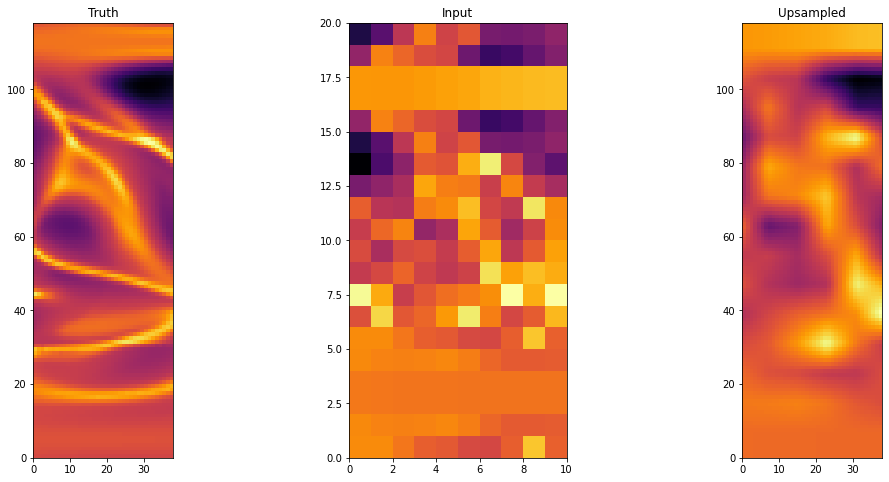

In [10]:
sample = earth_dataset[0]

color_scheme='inferno'
fig, ax = plt.subplots(1,3, figsize=(18,8))

title_list = ['Truth', 'Input', 'Upsampled']
for i, k in enumerate(sample.keys()):
    ax[i].pcolormesh(sample[k][0,0,:,:], cmap=color_scheme)
    ax[i].set_aspect(1)
    ax[i].set_title(title_list[i])
    
plt.savefig('truth_input.png', dpi=150)
plt.show()

In [11]:
sample[k][0,0,:,:].shape

torch.Size([118, 38])

In [6]:
dataset_loader = torch.utils.data.DataLoader(earth_dataset,
                                             batch_size=2, shuffle=True,
                                             num_workers=2)

In [7]:
dataset_loader

In [8]:
for i in dataset_loader:
    print(type(i))

<class 'dict'>


In [9]:
i['truth'].shape

torch.Size([2, 4, 198, 118, 38])

# Import Dataloader from src

In [10]:
from src.models.utils.create_batch import EarthDataTrain

In [11]:
root_dir = Path.cwd().parent # set the root directory as a Pathlib path

path_input_folder = root_dir / 'data/processed/input'
path_truth_folder = root_dir / 'data/processed/truth'

earth_dataset = EarthDataTrain(path_input_folder, path_truth_folder)

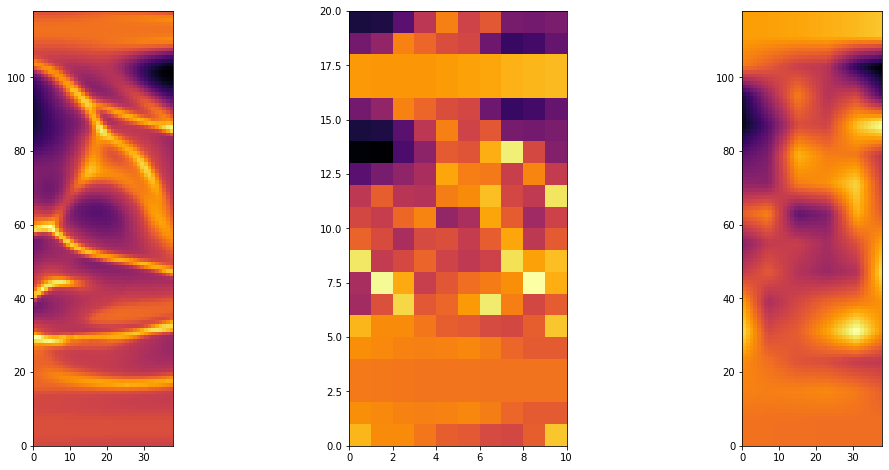

In [8]:
sample = earth_dataset[0]

color_scheme='inferno'
fig, ax = plt.subplots(1,3, figsize=(18,8))

for i, k in enumerate(sample.keys()):
    ax[i].pcolormesh(sample[k][0,0,:,:], cmap=color_scheme)
    ax[i].set_aspect(1)
    

plt.show()

In [24]:
loader = DataLoader(
    earth_dataset,
    batch_size=2,
    shuffle=True,
)

In [25]:
for batch_idx, data in enumerate(loader):
    x = data

In [26]:
x.keys()

dict_keys(['truth', 'input', 'upsampled'])

In [27]:
x['truth'].shape

torch.Size([2, 4, 198, 118, 38])

In [28]:
x['input'].shape

torch.Size([2, 4, 30, 20, 10])

In [29]:
x['upsampled'].shape

torch.Size([2, 4, 198, 118, 38])